In [42]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data.csv')

In [44]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [45]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [57]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [58]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [59]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [60]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [61]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [62]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 6s 147ms/step - loss: 0.0236 - val_loss: 9.8536e-05
Epoch 2/100
21/21 [==============================] - 1s 55ms/step - loss: 0.0023 - val_loss: 8.7104e-05
Epoch 3/100
21/21 [==============================] - 2s 90ms/step - loss: 8.1031e-04 - val_loss: 8.8250e-05
Epoch 4/100
21/21 [==============================] - 1s 66ms/step - loss: 5.8981e-04 - val_loss: 1.8609e-04
Epoch 5/100
21/21 [==============================] - 1s 42ms/step - loss: 5.7927e-04 - val_loss: 1.8769e-04
Epoch 6/100
21/21 [==============================] - 1s 42ms/step - loss: 5.1324e-04 - val_loss: 7.9548e-05
Epoch 7/100
21/21 [==============================] - 1s 41ms/step - loss: 4.9015e-04 - val_loss: 7.6867e-05
Epoch 8/100
21/21 [==============================] - 1s 43ms/step - loss: 4.7417e-04 - val_loss: 7.5894e-05
Epoch 9/100
21/21 [==============================] - 1s 42ms/step - loss: 4.5557e-04 - val_loss: 8.2346e-05
Epoch 10/100
21/21 [===============

In [63]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 11ms/step


In [64]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [65]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 26773.166127026994


In [66]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.2714661955833435], [0.2679639458656311], [0.2628963887691498], [0.2572523057460785], [0.2514151632785797], [0.24555355310440063], [0.23974625766277313], [0.23403292894363403], [0.22843486070632935], [0.2229640632867813], [0.21762725710868835], [0.21242795884609222], [0.20736731588840485], [0.20244500041007996], [0.19765955209732056], [0.1930086761713028], [0.1884894222021103], [0.18409845232963562], [0.1798320710659027], [0.17568650841712952], [0.17165790498256683], [0.16774220764636993], [0.16393549740314484], [0.16023391485214233], [0.15663358569145203], [0.1531308889389038], [0.149722158908844], [0.146403968334198], [0.14317291975021362], [0.14002585411071777], [0.13695965707302094], [0.1339714229106903], [0.13105830550193787], [0.1282176375389099], [0.12544679641723633], [0.12274335324764252], [0.12010496109724045], [0.11752938479185104], [0.11501450091600418], [0.1125582829117775], [0.1101587563753128], [0.10781405866146088], [0.10552244633436203], [0.10328216105699539], [0.10

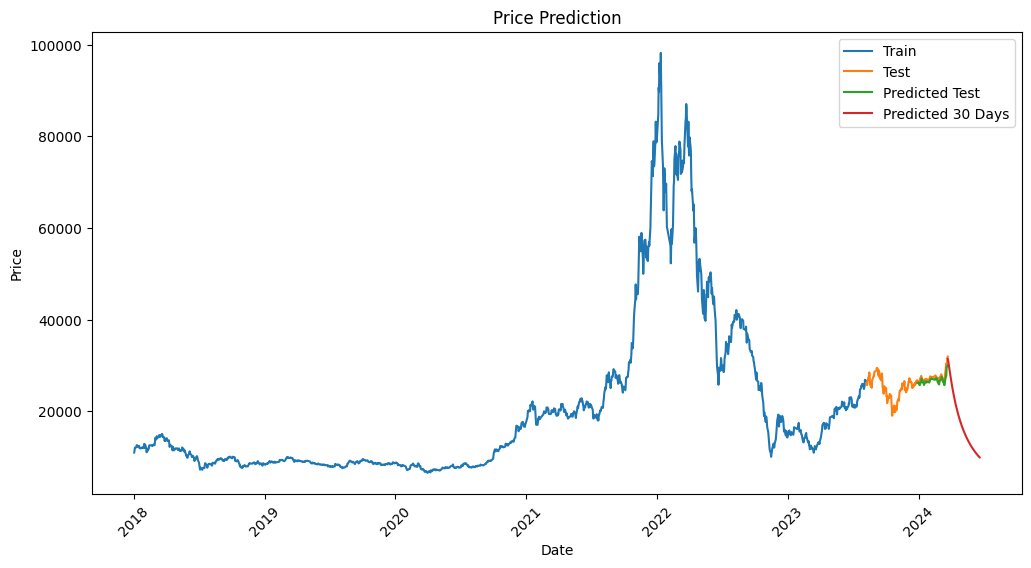

In [67]:
plt.figure(figsize=(12,6))

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Plot train data
train_dates = df['Date'][:train_size]
plt.plot(train_dates, scaler.inverse_transform(train_data), label='Train')

# Plot test data
test_dates = df['Date'][train_size:train_size + test_size]
plt.plot(test_dates, scaler.inverse_transform(test_data), label='Test')

# Plot predictions for test data
test_predict_dates = df['Date'][train_size + time_step:train_size + time_step + len(y_pred)]
plt.plot(test_predict_dates, y_pred, label='Predicted Test')

# Predict next 30 days
last_date = df['Date'].iloc[-1]
predict_30_days_dates = pd.date_range(start=last_date, periods=90)
plt.plot(predict_30_days_dates, scaler.inverse_transform(lst_output), label='Predicted 90 Days')

# Formatting the plot
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction')
plt.xticks(rotation=45)
plt.show()
